# Merge all Config Manager features into one dataframe
### Step 1: Load data into pandas dataframes 
Our team has spent some time in creating features from the tables in the Microsoft Configuration Manager database. Our features are stored in separate sources for each Config Manager table that we created features from. We have two types of data sources of features that we need to join together for our model:
1. `.parquet` files in blob storage 
2. SQL views from our cloud database 

We have tracked the data source file names and SQL views using a spreadsheet, and will use this list to pull the filenames and data from our cloud database and blob storage.


In [1]:
# Import modules 
from azure.storage.blob import BlobServiceClient
import missingno as msno
import pandas as pd 
import numpy
import pyodbc
import os
import json
import time

# Set the notebook to display all columns of a dataframe
pd.set_option('display.max_columns', None)

# Function Definitions --------------

def download_blob(cred, LOCALFILENAME,
                  CONTAINERNAME, BLOBNAME):

    # Start tracking download time
    t1=time.time()

    # Instantiate a blob service instance
    blob_service_client_instance = BlobServiceClient(account_url=cred['in_the_sun'], credential=cred['fun'])
    blob_client_instance = blob_service_client_instance.get_blob_client(CONTAINERNAME, BLOBNAME, snapshot=None)

    # Create the file locally
    with open(LOCALFILENAME, "wb") as my_blob:
        blob_data = blob_client_instance.download_blob()
        blob_data.readinto(my_blob)
    
    # Notify user of download time 
    t2=time.time()
    print(("It takes %s seconds to download "+BLOBNAME) % (t2 - t1))

def connect_to_database(cred):
    ''' 
    Uses pyodbc to connect to a SQL Server database
    and returns the connection object
    '''
    # Define database driver, server, database
    driver = 'SQL SERVER'

    # Define the connection string
    conn_str = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={cred['server']};DATABASE={cred['db']};UID={cred['uid']};PWD={cred['pwd']}"

    # Connect to database using windows authentication 
    conn = pyodbc.connect(conn_str)

    return conn 

def get_sql_data(persist_conn_obj, sql_query):
    ''' 
    Gets rows from a table in the SQL database connection
    '''
    # Execute a query for table table
    df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)
    
    return df_pers_all

def get_creds(in_file):
    with open(in_file) as f:
        cred = json.load(f)
    return cred

# Get creds 
creds_file = 'assets/fun.json'
creds = get_creds(creds_file)


In [2]:
def get_feature_metadata():

    # Read the EDA feature metadata 
    df = pd.read_excel('assets/EDA _ Feature Engineering Tasks.xlsx', sheet_name='Features to Engineer')

    # Select only completed features 
    df['Completed? (Y/N)'] = df['Completed? (Y/N)'].apply(lambda x: x.strip())
    df = df[df['Completed? (Y/N)'] == 'Y']

    # Get only one row per view/filename
    out_df = df[['Completed dataset location', 'View/Filename', 'Keys']]
    out_df = out_df.drop_duplicates()

    return out_df

def download_all_data(metadata_df, save_directory, creds):

    # Instantiate a dictionary to accumulate dataframes
    feature_dfs = {}

    # Start a SQL connection 
    conn = connect_to_database(creds)

    # Iterate through each view/file
    for row in metadata_df.iterrows():
        
        row = row[1]

        # Download and read Blob file
        if row['Completed dataset location'] == 'Blob Storage':
            
            # Download from blob storage
            blob_name = row['View/Filename']
            file_save_name = os.path.join(save_directory, blob_name)
            download_blob(creds, file_save_name, 'configmanagertest1', blob_name)

            # Read the blob into a dataframe and add to output dict
            current_df = pd.read_parquet(file_save_name)
            feature_dfs[blob_name] = current_df

        # Download and read SQL 
        if row['Completed dataset location'] == 'SQL View':
            
            # Call SQL to get data
            view_name = row['View/Filename']
            sql_query = f'SELECT * FROM {view_name}'
            current_df = get_sql_data(conn, sql_query)

            # Add data to output dict
            feature_dfs[view_name] = current_df
            print(f'retrieved {view_name} from SQL')
    
    # Close the SQL connection
    conn.close()

    return feature_dfs

# Download data 
save_location = 'assets/features'
df = get_feature_metadata()
feature_datasets = download_all_data(df, save_location, creds)


It takes 0.5529379844665527 seconds to download add_remove_programs_features.parquet
It takes 0.31650614738464355 seconds to download office_addin_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_88587/2976849977.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Machine_Enclosure_Types from SQL
It takes 0.236983060836792 seconds to download update_summary_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_88587/2976849977.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Battery_Health_View from SQL
It takes 0.5289301872253418 seconds to download browser_usage_features.parquet
It takes 0.3306701183319092 seconds to download computer_system_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_88587/2976849977.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Logical_Disk_Data_View from SQL
retrieved Machine_Office_Is32Bit from SQL
retrieved Office_Readiness_View from SQL
retrieved Processor_DATA_View from SQL
It takes 0.3717789649963379 seconds to download user_count_feature.parquet
It takes 0.5973918437957764 seconds to download boot_events_parsed_features.pq
It takes 0.20982980728149414 seconds to download num_events.pq
It takes 0.29769396781921387 seconds to download operating_system_features.pq
It takes 0.18803668022155762 seconds to download pc_bios_data.pq
It takes 0.16936874389648438 seconds to download pc_memory_data.pq
It takes 1.3020691871643066 seconds to download system_disc_features.pq
It takes 1.5634303092956543 seconds to download workstationstatus_features.pq
It takes 0.14127326011657715 seconds to download num_events_office.pq
It takes 0.11437416076660156 seconds to download num_events_inc.pq


In [3]:
# Function to yield a generator of dataframes 
def view_data(in_dict):

    for key in in_dict.keys():
        
        dat = in_dict[key]
        if 'RWB_EFFECTIVE_DATE' in dat.columns:
            dat['RWB_EFFECTIVE_DATE'] = pd.to_datetime(dat['RWB_EFFECTIVE_DATE'])
            min_date = dat['RWB_EFFECTIVE_DATE'].min()
            max_date = dat['RWB_EFFECTIVE_DATE'].max()
            print(key, f"MIN_DATE: {min_date}", f"MAX_DATE: {max_date}" )
        yield dat

generator = view_data(feature_datasets)

In [4]:
# View each dataframe 
# current = next(generator)
# current.head()
for val in generator:
    pass

add_remove_programs_features.parquet MIN_DATE: 2023-01-28 00:00:00 MAX_DATE: 2023-07-04 00:00:00
office_addin_features.parquet MIN_DATE: 2023-02-02 00:00:00 MAX_DATE: 2023-07-04 00:00:00
Battery_Health_View MIN_DATE: 2023-01-28 00:00:00 MAX_DATE: 2023-07-02 00:00:00
browser_usage_features.parquet MIN_DATE: 2023-02-01 00:00:00 MAX_DATE: 2023-07-02 00:00:00
Logical_Disk_Data_View MIN_DATE: 2023-01-19 00:00:00 MAX_DATE: 2023-07-04 00:00:00
Machine_Office_Is32Bit MIN_DATE: 2023-01-31 00:00:00 MAX_DATE: 2023-07-04 00:00:00
Office_Readiness_View MIN_DATE: 2023-02-01 00:00:00 MAX_DATE: 2023-07-02 00:00:00
Processor_DATA_View MIN_DATE: 2023-01-25 00:00:00 MAX_DATE: 2023-07-02 00:00:00
user_count_feature.parquet MIN_DATE: 2023-01-19 00:00:00 MAX_DATE: 2023-07-04 00:00:00
boot_events_parsed_features.pq MIN_DATE: 2022-08-30 00:00:00 MAX_DATE: 2023-07-18 00:00:00
operating_system_features.pq MIN_DATE: 2023-01-19 00:00:00 MAX_DATE: 2023-07-04 00:00:00
pc_bios_data.pq MIN_DATE: 2023-01-19 00:00:00 M

In [5]:
events_grouped = feature_datasets['num_events.pq']
events_grouped['events'].sum()

317218

### Step 2: Join all features into one dataframe 


In [8]:
def join_all_features(features_dict, metadata_df):

    # Get the system_disc table 
    system_name = 'system_disc_features.pq'
    system_df = features_dict[system_name]

    # Drop rows in system_disc that have may 20th 2023
    system_df = system_df[system_df['RWB_EFFECTIVE_DATE'] != '2023-05-20']

    # Update the type of RWB_EFFECTIVE_DATE to str
    system_df['RWB_EFFECTIVE_DATE'] = system_df['RWB_EFFECTIVE_DATE'].astype(str)

    # Iterate through each file 
    for row in metadata_df.iterrows():
        row = row[1]

        # Get the table and key on the right to join to system disc
        right_df_name = row['View/Filename']
        right_df = features_dict[right_df_name]
        right_keys = row['Keys'].split(', ')

        if right_df_name == 'num_events_inc.pq':
            right_df = right_df.rename(columns={"events":"impactful_events"})
        if right_df_name == 'num_events_office.pq':
            right_df = right_df.rename(columns={"events":"office_events"})

        # skip if df is system disc
        if right_df_name == system_name:
            continue
        
        # Get the system disc key and change type of right key date
        if 'RWB_EFFECTIVE_DATE' in right_keys:
            left_keys = ['ItemKey', 'RWB_EFFECTIVE_DATE']
            right_df['RWB_EFFECTIVE_DATE'] = right_df['RWB_EFFECTIVE_DATE'].astype(str)
            right_df = right_df[right_df['RWB_EFFECTIVE_DATE'] != '2023-05-20']
        elif 'created_date' in right_keys:
            left_keys = ['ItemKey', 'RWB_EFFECTIVE_DATE']
            right_df['created_date'] = right_df['created_date'].astype(str)
        elif 'CreatedSystemTime_CST_formatted' in right_keys:
            right_df['CreatedSystemTime_CST_formatted'] = right_df['CreatedSystemTime_CST_formatted'].astype(str)
            right_df['ClientItemKey'] = right_df['ClientItemKey'].astype(int)
        else:
            left_keys = ['ItemKey']

        # Perform a left join for the features 
        system_df = pd.merge(system_df, right_df, 
                             how='left',
                             left_on=left_keys,
                             right_on=right_keys,
                             copy=False)
        
        if 'MachineID' in system_df.columns:
            system_df = system_df.drop('MachineID', axis=1)
        elif 'ClientItemKey' in system_df.columns:
            system_df = system_df.drop('ClientItemKey', axis=1)
        elif 'created_date' in system_df.columns:
            system_df = system_df.drop('created_date', axis=1)
        elif 'CreatedSystemTime_CST_formatted' in system_df.columns:
            system_df = system_df.drop('CreatedSystemTime_CST_formatted', axis=1)
        
    return system_df

final_df = join_all_features(feature_datasets, df)

/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_88587/1650386248.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_df['RWB_EFFECTIVE_DATE'] = system_df['RWB_EFFECTIVE_DATE'].astype(str)


In [9]:
final_df.head()

,ItemKey,RWB_EFFECTIVE_DATE,Is_Virtual_Machine0,Client0,Active0,Days Since Creation,Days Since Last Logon,has_powerbi,num_installed_programs,avg_software_age,num_x64addins,num_x86addins,x64add_avgloadtime,x86add_avgloadtime,has_cap_iq_add,has_factset_add,has_bluematrix_add,has_bloomberg_add,has_acrobat_add,Accessx86_addin_filesize,Excelx64_addin_filesize,Excelx86_addin_filesize,OneNotex64_addin_filesize,OneNotex86_addin_filesize,Outlookx64_addin_filesize,Outlookx86_addin_filesize,PowerPointx64_addin_filesize,PowerPointx86_addin_filesize,Publisherx86_addin_filesize,Wordx64_addin_filesize,Wordx86_addin_filesize,CaseType,created_date,num_updates,num_windows_64_os_updates,num_office_updates,Battery_Power,AC_Power,EstimatedRunTime00,MicrosoftEdgeCP_usage,chrome_usage,firefox_usage,iexplore_usage,msedge_usage,opera_usage,Model,system_type,TotalSpace_GB,FreeSpace_GB,is_32bit_office,is_64bit_office,Has32BitMacro,Has64BitMacro,Has32BitOffice97_2003Files,Has64BitOffice97_2003Files,NumCPUs,AvgProcessorNormSpeed,num_users,TotalBootDurationInMilliseconds,CreatedSystemTime_CST_formatted_x,events,InstallDate00,LastBootUpTime00,TotalVirtualMemorySize00,InstallAge,LastBootAge,BIOS Release Date,BIOSReleaseAge,Total RAM,Total Page File Space,LastHWScan,LastHWScan_Days,CreatedSystemTime_CST_formatted_y,office_events,CreatedSystemTime_CST_formatted,impactful_events
0,16783564,2022-08-30,True,1.0,1.0,1545,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VMware Virtual Platform,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88739.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16783564,2022-08-31,True,1.0,1.0,1546,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VMware Virtual Platform,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16783564,2022-09-01,True,1.0,1.0,1547,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VMware Virtual Platform,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16783564,2022-09-02,True,1.0,1.0,1548,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VMware Virtual Platform,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16783564,2022-09-03,True,1.0,1.0,1549,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Others,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,VMware Virtual Platform,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

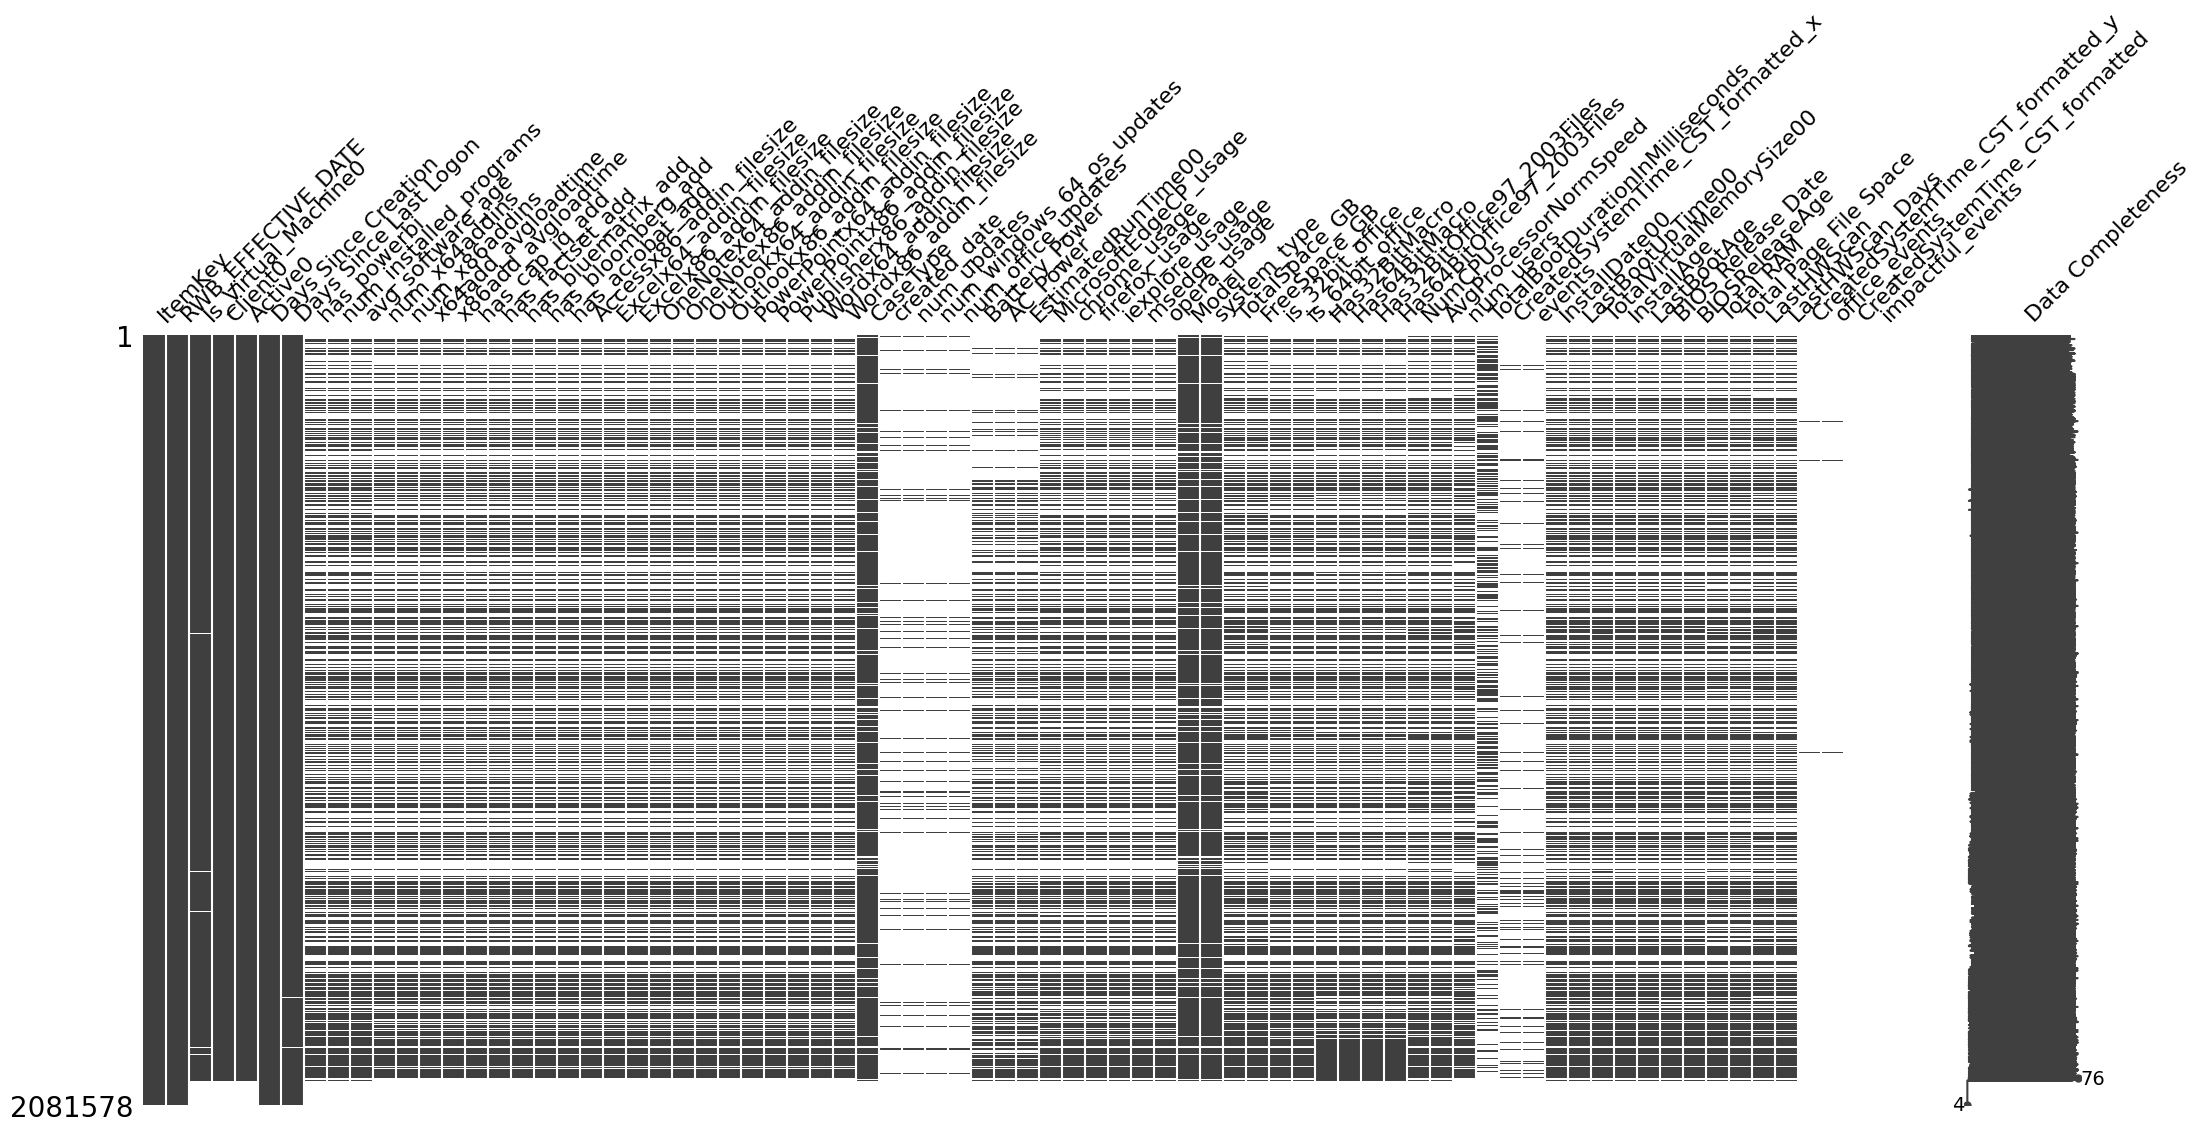

In [10]:
# View MissingNo matrix
msno.matrix(final_df, labels=True)

In [11]:
# Quick look into nullness in update events
update_df = feature_datasets['update_summary_features.parquet']
print('number of unique machines in Update Events: ', len(update_df['ClientItemKey'].unique()))
print('number of unique machines in System DISC: ', len(final_df['ItemKey'].unique()))

number of unique machines in Update Events:  7894
number of unique machines in System DISC:  16001


In [12]:
# Quick look into nullness in BOOT and App Crash events
boot_df = feature_datasets['boot_events_parsed_features.pq']
events_df = feature_datasets['num_events.pq']
print('number of unique machines in BOOT Events: ', len(boot_df['ClientItemKey'].unique()))
print('number of unique machines in APP CRASH/HANG Events: ', len(events_df['ClientItemKey'].unique()))
print('number of unique machines in System DISC: ', len(final_df['ItemKey'].unique()))

number of unique machines in BOOT Events:  10962
number of unique machines in APP CRASH/HANG Events:  7250
number of unique machines in System DISC:  16001


In [14]:
def investigate_nullness(in_df):

    out_dict = {}
    out_dict['Attribute'] = []
    out_dict['Not_Null_Count'] = []

    for col in in_df.columns:

        # Grab number of non-null records for 
        # each attribute
        out_dict['Attribute'].append(col)
        out_dict['Not_Null_Count'].append(len(in_df[in_df[col].notnull()]))

    out_df = pd.DataFrame(out_dict)
    out_df = out_df.sort_values('Not_Null_Count', ascending=True)
    
    return out_df

null_summary_df = investigate_nullness(final_df)
null_summary_df.head(10)

,Attribute,Not_Null_Count
75,impactful_events,1897
74,CreatedSystemTime_CST_formatted,1897
73,office_events,29531
72,CreatedSystemTime_CST_formatted_y,29531
35,num_office_updates,168047
34,num_windows_64_os_updates,168047
33,num_updates,168047
32,created_date,168047
60,events,187258
59,CreatedSystemTime_CST_formatted_x,187258


### Observations 
* Attributes that were created from software inventory tables do not have as much coverage as attributes that were created from the hardware inventory views.
* It appears that update events are not captured for all machines. However, a total of 7894 machines in the update events dataset does sound correct for the number of laptops and desktops in the organization. 

## Feature cleaning notes 

### High null counts 
* Fill null values for update events with zero
* Drop TotalBootDurationInMilliseconds 
* Fill Missing values for boolean battery features with 0, assuming that if there are no battery data that the machine does not have a battery
* For EstimatedRunTime00, fill missing values with extreme values that occur outside of the range of given values, assuming that the machine is always plugged in and will run infinitely
* Fill boolean addin features with zero
* Fill boolean programs features with zero

### Removing date features 
We need to remove the following date features so our model only contains numeric values:

`['created_date', 'InstallDate00', 'LastBootUpTime00', 'BIOS Release Date', 'LastHWScan']`

### Drop rows that have any `NaN` value
Given time constraints and dataset size, we will be dropping any rows that have a `NaN` missing value. Future work may attempt to impute the missing values. We will save the records that were dropped to do analysis and check for patterns in machine characteristics to make sure we are not losing a large subset of machine categories.

### Step 3: Clean the joined dataset

In [15]:
def handle_nan_columns(in_features, in_df):

    # Function for filling NaNs with zero
    fill_col_nan = lambda col: in_df[col].apply(lambda x: 0 if pd.isna(x) else x)

    # Call fill na function 
    for feature in in_features:
        
        # Fill missing estimated run time with extreme values
        if feature == 'EstimatedRunTime00':
            max_val = in_df[feature].max() * 100
            in_df[feature] = in_df[feature].apply(lambda x: max_val if pd.isna(x) else x)
        else:
            in_df[feature] = fill_col_nan(feature)

    return in_df

def clean_joined_data(in_df, return_impactful=False, return_office=False):

    # fill missing values with zero for update columns
    update_features = ['num_updates', 'num_windows_64_os_updates','num_office_updates']
    
    # fill missing values with zero for addin and program columns
    boolean_features_addins_programs = ['has_powerbi', 'num_installed_programs',
       'num_x64addins', 'num_x86addins', 'x64add_avgloadtime',
       'x86add_avgloadtime', 'has_cap_iq_add', 'has_factset_add',
       'has_bluematrix_add', 'has_bloomberg_add', 'has_acrobat_add',
       'Accessx86_addin_filesize', 'Excelx64_addin_filesize',
       'Excelx86_addin_filesize', 'OneNotex64_addin_filesize',
       'OneNotex86_addin_filesize', 'Outlookx64_addin_filesize',
       'Outlookx86_addin_filesize', 'PowerPointx64_addin_filesize',
       'PowerPointx86_addin_filesize', 'Publisherx86_addin_filesize',
       'Wordx64_addin_filesize', 'Wordx86_addin_filesize']
    
    # Define battery features 
    battery_features = ['Battery_Power', 'AC_Power', 'EstimatedRunTime00']

    features_to_fill = update_features + boolean_features_addins_programs + battery_features
    in_df = handle_nan_columns(features_to_fill, in_df)
    
    # drop Total Boot duration in Milliseconds and remove date features
    high_nulls = ['TotalBootDurationInMilliseconds', 'CreatedSystemTime_CST_formatted']
    date_features = ['created_date', 'InstallDate00', 'LastBootUpTime00',
                      'BIOS Release Date', 'LastHWScan', 'CreatedSystemTime_CST_formatted_y',
                      'CreatedSystemTime_CST_formatted_x', 'CreatedSystemTime_CST_formatted_y']
    cols_to_drop = high_nulls + date_features
    out_df = in_df[[col for col in in_df.columns if col not in cols_to_drop]]

    # If event data is NaN, let's assume the machine did not 
    # have an event for that day.
    if return_impactful:
        # Assign events variable the number of impactful events
        out_df['events'] = out_df['impactful_events'].apply(lambda x: x if pd.notnull(x) else 0)
    
    if return_office:
        # Assign events variable the number of office events
        out_df['events'] = out_df['office_events'].apply(lambda x: x if pd.notnull(x) else 0)

    else:
        out_df['events'] = out_df['events'].apply(lambda x: x if pd.notnull(x) else 0)

    # Drop the impactful and office events attribute 
    out_df = out_df.drop('impactful_events', axis=1)
    out_df = out_df.drop('office_events', axis=1)

    # Drop rows with any NaN value
    out_df = out_df.dropna(axis=0, how='any')

    # For impactful events, keep only 10,000 records where the number of events is zero
    if return_impactful:
        zero_df = out_df[out_df['events'] == 0]
        nonzero_df = out_df[out_df['events'] > 0]
        zero_df = zero_df.sample(10000, random_state=42)
        out_df = pd.concat([zero_df, nonzero_df], axis=0)

    if return_office:
        zero_df = out_df[out_df['events'] == 0]
        nonzero_df = out_df[out_df['events'] > 0]
        zero_df = zero_df.sample(40000, random_state=42)
        out_df = pd.concat([zero_df, nonzero_df], axis=0)

    # Drop columns that have only one value
    for col in out_df.columns:
        if len(out_df[col].unique()) <= 1:
            print(col)
            out_df = out_df.drop(col, axis=1)

    return out_df

cleaned_df = clean_joined_data(final_df, return_impactful=False, return_office=True)
cleaned_df.head()

/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_88587/2998630400.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_df['events'] = out_df['office_events'].apply(lambda x: x if pd.notnull(x) else 0)


Active0
MicrosoftEdgeCP_usage
opera_usage
system_type


,ItemKey,RWB_EFFECTIVE_DATE,Is_Virtual_Machine0,Client0,Days Since Creation,Days Since Last Logon,has_powerbi,num_installed_programs,avg_software_age,num_x64addins,num_x86addins,x64add_avgloadtime,x86add_avgloadtime,has_cap_iq_add,has_factset_add,has_bluematrix_add,has_bloomberg_add,has_acrobat_add,Accessx86_addin_filesize,Excelx64_addin_filesize,Excelx86_addin_filesize,OneNotex64_addin_filesize,OneNotex86_addin_filesize,Outlookx64_addin_filesize,Outlookx86_addin_filesize,PowerPointx64_addin_filesize,PowerPointx86_addin_filesize,Publisherx86_addin_filesize,Wordx64_addin_filesize,Wordx86_addin_filesize,CaseType,num_updates,num_windows_64_os_updates,num_office_updates,Battery_Power,AC_Power,EstimatedRunTime00,chrome_usage,firefox_usage,iexplore_usage,msedge_usage,Model,TotalSpace_GB,FreeSpace_GB,is_32bit_office,is_64bit_office,Has32BitMacro,Has64BitMacro,Has32BitOffice97_2003Files,Has64BitOffice97_2003Files,NumCPUs,AvgProcessorNormSpeed,num_users,events,TotalVirtualMemorySize00,InstallAge,LastBootAge,BIOSReleaseAge,Total RAM,Total Page File Space,LastHWScan_Days
1206946,16811894,2023-02-03,False,1.0,254,4.0,0.0,53.0,329.357143,6.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,805720.0,1173072.0,0.0,0.0,1195016.0,4374752.0,607696.0,1067400.0,0.0,607696.0,1111392.0,Laptop,0.0,0.0,0.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,Latitude 9520,476.0,383.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3000.0,1.0,0.0,32490.0,405.0,1.0,291.0,16492932.0,16777216.0,1.0
1897257,16816587,2023-04-12,False,1.0,78,13.0,0.0,42.0,326.156250,9.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,996064.0,1336744.0,0.0,0.0,1335728.0,6457656.0,607696.0,1067384.0,0.0,747352.0,1225960.0,Laptop,0.0,0.0,0.0,0.0,1.0,71582788.0,97.0,0.0,0.0,3.0,Latitude 9520,476.0,375.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3000.0,1.0,0.0,32490.0,368.0,9.0,309.0,16492932.0,16777216.0,9.0
708559,16807087,2023-05-30,False,1.0,590,6.0,0.0,60.0,572.000000,18.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1352744.0,737624.0,0.0,0.0,5143904.0,1118280.0,1291216.0,539600.0,0.0,1357240.0,539600.0,Laptop,0.0,0.0,0.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,Latitude 9520,476.0,306.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3000.0,1.0,0.0,32490.0,708.0,0.0,250.0,16492932.0,16777216.0,0.0
1389002,16813132,2023-04-21,False,1.0,246,1.0,0.0,45.0,288.088235,6.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,805720.0,1173000.0,0.0,0.0,1195592.0,4373728.0,607696.0,1066928.0,0.0,607696.0,1110880.0,Laptop,0.0,0.0,0.0,0.0,1.0,71582788.0,1.0,0.0,0.0,99.0,Latitude 9520,476.0,340.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3000.0,2.0,0.0,32490.0,320.0,1.0,250.0,16492932.0,16777216.0,1.0
1740928,16815114,2023-03-04,False,1.0,148,9.0,0.0,45.0,588.852941,6.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1994880.0,1973112.0,90360.0,90360.0,2358056.0,5158472.0,1796856.0,2371232.0,0.0,1796856.0,2415664.0,Laptop,0.0,0.0,0.0,1.0,0.0,86.0,99.0,0.0,0.0,1.0,Latitude 7320,237.0,100.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3000.0,1.0,0.0,32490.0,693.0,2.0,293.0,16492932.0,16777216.0,1.0


### Observations 
* Machines with `system_type` that are `x86_64` and `arm64` are dropped from the data when we drop rows with any `NaN` values.
* Only 10% of the final joined dataset remains after dropping rows with any `NaN` values.

In [16]:
print('final_df length:', len(final_df))
print('cleaned_df length:', len(cleaned_df))
#181352

final_df length: 2081578
cleaned_df length: 63978


In [17]:
# Compare models that were dropped
print(cleaned_df['Model'].unique())
print(final_df['Model'].unique())

['Latitude 9520' 'Latitude 7320' 'OptiPlex 5060' 'Latitude 7300'
 'OptiPlex 5070' 'Precision Tower 3430' 'Latitude 5500' 'Precision 3561'
 'Precision Tower 3431' 'Latitude 9510' 'Surface Pro 7' 'Latitude 5510'
 'Latitude 7530' 'Latitude 7330' 'Precision 3571'
 'Latitude 7320 Detachable' 'Precision 7680' 'Latitude 5590'
 'Precision 3450' 'VMware Virtual Platform' 'Latitude 7290'
 'Precision 5760' 'OptiPlex 5050' 'Latitude E7270' 'Surface Pro 7+'
 'Latitude 7340' 'Latitude E7470' 'OptiPlex 5080' 'VMware7,1'
 'Virtual Machine']
['VMware Virtual Platform' 'Latitude E7270' nan 'OptiPlex 5050'
 'Latitude 5590' 'Precision Tower 3430' 'Latitude 7290' 'OptiPlex 5060'
 'Surface Pro 6' 'Latitude E7470' 'Latitude 7300' 'OptiPlex 5070'
 'Latitude 5500' 'Precision Tower 3431' 'Surface Pro 7' 'Latitude 5510'
 'Latitude 9510' 'Latitude 9520' 'MacBook Pro (16-inch, 2019)'
 'Latitude 7320' 'MacBook Pro (15-inch, 2018)' 'Latitude 7320 Detachable'
 'Surface Pro 7+' 'Precision 3561' 'MacBook Pro (16-inch, 

In [41]:
# optional, view data in Dtale
import dtale
dtale.show(cleaned_df).open_browser() 

In [18]:
import plotly.express as px
fig = px.histogram(cleaned_df, x="events", log_y=True, title="Histogram of number of events per machine per day in log scale")
fig.show()

### Step 5: Encode Categorical Features

In [19]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

def encode_attr(in_df, attrs):
    
    # Get the category labels and  categories
    categories = [(attr, list(in_df[attr].unique())) for attr in attrs]
    ohe_columns = [x[0] for x in categories]
    ohe_categories = [x[1] for x in categories]

    # Instantiate the one hot encoder and fit it 
    enc = OneHotEncoder(sparse_output=False, categories=ohe_categories)
    transformer = make_column_transformer((enc, ohe_columns), remainder='passthrough')
    output = transformer.fit_transform(in_df)

    # Put results in dataframe and clean up columns
    out_df = pd.DataFrame(output, columns=transformer.get_feature_names_out())
    remainder_cols =  [col[11:] for col in out_df.columns if 'remainder' in col]
    encoded_cols = [col[15:] for col in out_df.columns if 'onehotencoder' in col]
    out_df.columns = encoded_cols + remainder_cols
    out_df = out_df[remainder_cols + encoded_cols]

    return out_df

encoded_clean_df = encode_attr(cleaned_df, ['Model', 'CaseType'])

In [20]:
encoded_clean_df.head()

,ItemKey,RWB_EFFECTIVE_DATE,Is_Virtual_Machine0,Client0,Days Since Creation,Days Since Last Logon,has_powerbi,num_installed_programs,avg_software_age,num_x64addins,num_x86addins,x64add_avgloadtime,x86add_avgloadtime,has_cap_iq_add,has_factset_add,has_bluematrix_add,has_bloomberg_add,has_acrobat_add,Accessx86_addin_filesize,Excelx64_addin_filesize,Excelx86_addin_filesize,OneNotex64_addin_filesize,OneNotex86_addin_filesize,Outlookx64_addin_filesize,Outlookx86_addin_filesize,PowerPointx64_addin_filesize,PowerPointx86_addin_filesize,Publisherx86_addin_filesize,Wordx64_addin_filesize,Wordx86_addin_filesize,num_updates,num_windows_64_os_updates,num_office_updates,Battery_Power,AC_Power,EstimatedRunTime00,chrome_usage,firefox_usage,iexplore_usage,msedge_usage,TotalSpace_GB,FreeSpace_GB,is_32bit_office,is_64bit_office,Has32BitMacro,Has64BitMacro,Has32BitOffice97_2003Files,Has64BitOffice97_2003Files,NumCPUs,AvgProcessorNormSpeed,num_users,events,TotalVirtualMemorySize00,InstallAge,LastBootAge,BIOSReleaseAge,Total RAM,Total Page File Space,LastHWScan_Days,Model_Latitude 9520,Model_Latitude 7320,Model_OptiPlex 5060,Model_Latitude 7300,Model_OptiPlex 5070,Model_Precision Tower 3430,Model_Latitude 5500,Model_Precision 3561,Model_Precision Tower 3431,Model_Latitude 9510,Model_Surface Pro 7,Model_Latitude 5510,Model_Latitude 7530,Model_Latitude 7330,Model_Precision 3571,Model_Latitude 7320 Detachable,Model_Precision 7680,Model_Latitude 5590,Model_Precision 3450,Model_VMware Virtual Platform,Model_Latitude 7290,Model_Precision 5760,Model_OptiPlex 5050,Model_Latitude E7270,Model_Surface Pro 7+,Model_Latitude 7340,Model_Latitude E7470,Model_OptiPlex 5080,"Model_VMware7,1",Model_Virtual Machine,CaseType_Laptop,CaseType_Desktop,CaseType_Others
0,16811894,2023-02-03,False,1.0,254,4.0,0.0,53.0,329.357143,6.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,805720.0,1173072.0,0.0,0.0,1195016.0,4374752.0,607696.0,1067400.0,0.0,607696.0,1111392.0,0.0,0.0,0.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,476.0,383.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3000.0,1.0,0.0,32490.0,405.0,1.0,291.0,16492932.0,16777216.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,16816587,2023-04-12,False,1.0,78,13.0,0.0,42.0,326.15625,9.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,996064.0,1336744.0,0.0,0.0,1335728.0,6457656.0,607696.0,1067384.0,0.0,747352.0,1225960.0,0.0,0.0,0.0,0.0,1.0,71582788.0,97.0,0.0,0.0,3.0,476.0,375.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3000.0,1.0,0.0,32490.0,368.0,9.0,309.0,16492932.0,16777216.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,16807087,2023-05-30,False,1.0,590,6.0,0.0,60.0,572.0,18.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1352744.0,737624.0,0.0,0.0,5143904.0,1118280.0,1291216.0,539600.0,0.0,1357240.0,539600.0,0.0,0.0,0.0,0.0,1.0,71582788.0,100.0,0.0,0.0,0.0,476.0,306.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3000.0,1.0,0.0,32490.0,708.0,0.0,250.0,16492932.0,16777216.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,16813132,2023-04-21,False,1.0,246,1.0,0.0,45.0,288.088235,6.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,805720.0,1173000.0,0.0,0.0,1195592.0,4373728.0,607696.0,1066928.0,0.0,607696.0,1110880.0,0.0,0.0,0.0,0.0,1.0,71582788.0,1.0,0.0,0.0,99.0,476.0,340.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,3000.0,2.0,0.0,32490.0,320.0,1.0,250.0,16492932.0,16777216.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,16815114,2023-03-04,False,1.0,148,9.0,0.0,45.0,588.852941,6.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1994880.0,1973112.0,90360.0,90360.0,2358056.0,5158472.0,1796856.0,2371232.0,0.0,1796856.0,2415664.0,0.0,0.0,0.0,1.0,0.0,86.0,99.0,0.0,0.0,1.0,237.0,100.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3000.0,1.0,0.0,32490.0,693.0,2.0,293.0,16492932.0,16777216.0,1.0,0.

### Step 6: Split data into train, test, validation sets.

In [21]:
from sklearn.model_selection import train_test_split

def split_data_modelling(df):

    # Assuming your DataFrame is named 'df'
    # Splitting the data into train and temp sets (80% train + 20% temp)
    train_df, temp_df = train_test_split(df, test_size=0.1, random_state=42)

    # Splitting the temp set into test and validation sets (50% test + 50% validation)
    test_df, validation_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Printing the shapes of the resulting sets
    print("Train set shape:", train_df.shape)
    print("Test set shape:", test_df.shape)
    print("Validation set shape:", validation_df.shape)

    return train_df, validation_df, test_df

train_df, validation_df, test_df = split_data_modelling(encoded_clean_df)

# View shape of label distribution for training data in log scale 
fig = px.histogram(train_df, x="events", log_y=True, title="Histogram of number of events per machine per day from training data in log scale")
fig 

Train set shape: (57580, 92)
Test set shape: (3199, 92)
Validation set shape: (3199, 92)


### Step 5: undersample majority class from the training data

In [22]:
import numpy as np

def undersample_majority_labels(in_df, target_var, rare_boundary_threshold, random_state=42):
    
    # find the label at the boundary of label rarity
    rarity_boundary = np.percentile(in_df[target_var], rare_boundary_threshold)
    print(rarity_boundary)

    # Get the number of records in the minority class
    minority_df =in_df[in_df[target_var] > rarity_boundary]
    num_minority = len(minority_df)

    # get the labels in the majority 
    majority_df = in_df[in_df[target_var] <= rarity_boundary]
    maj_labs = majority_df[target_var].unique()

    # get the size of partitions for the majority labels
    partition_size = num_minority//len(maj_labs)

    # copy the minority df for the output
    output_df = minority_df.copy()

    for maj_label in maj_labs:
        
        # get the data for the majority label
        maj_df = in_df[in_df[target_var] ==  maj_label]

        # Randomly sample the data 
        maj_sample = maj_df.sample(partition_size, random_state=random_state)

        # add to output dataframe
        output_df = pd.concat([output_df, maj_sample], axis=0)

    print('shape of undersampled dataframe: ', output_df.shape)

    return output_df

train_undersamp_df = undersample_majority_labels(train_df, 'events', 85)

# Show the new training data label distribution 
fig = px.histogram(train_undersamp_df, x="events", log_y=True, title="Histogram of number of events per machine per day from undersampled training data in log scale")
fig

1.0
shape of undersampled dataframe:  (7964, 92)


In [23]:
# Export train, test, and validation sets to dataframe 
train_name = 'assets/training_set_office.parquet'
test_name = 'assets/test_set_impactful_office.parquet'
validate_name = 'assets/validation_set_office.parquet'

# Save datasets to parquet
train_undersamp_df.to_parquet(train_name)
test_df.to_parquet(test_name)
validation_df.to_parquet(validate_name)